In [1]:
rm(list= ls())
ls()

character(0)

In [2]:
.libPaths(c("/hsfscqjf2/ST_CQ/Reference/software/envs/RTest/lib/R/library",
"/hsfscqjf2/ST_CQ/Reference/software/R_lib/suncnv/lib/R/library",
"/hsfscqjf2/ST_CQ/Reference/software/R_lib",
"/hsfscqjf2/ST_CQ/Reference/PUB/scRNA/software/miniconda3/envs/lib/R/library",
"/hsfscqjf2/ST_CQ/Reference/software/envs/monocle3/lib/R/library",
"/hsfscqjf2/ST_CQ/Reference/software/envs/cellchat/lib/R/library"))

In [3]:
library(tidyverse)
library(ggplot2)
library(Matrix)
library(scales)
library(cowplot)
library(RCurl)
library(dplyr)
library(Seurat)
library(patchwork)
library(clustree)
library(ggsci)
library(scales)
library(RColorBrewer)
library(DoubletFinder)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    co

# filter doublet

In [4]:
resultdir<-"/hsfscqjf1/ST_CQ/P24Z32300N0020/hemingmin/bom/10.sc_merged1/results/"
figuredir<-"/hsfscqjf1/ST_CQ/P24Z32300N0020/hemingmin/bim/10.sc_merged1/results/figures/"


In [5]:
options(repr.plot.width =8, repr.plot.height=8)
pal = pal_igv("default")(11)

In [6]:
load(file=paste0(resultdir,"merged_seurat.RData"))

In [7]:
ob1

An object of class Seurat 
16122 features across 140390 samples within 1 assay 
Active assay: RNA (16122 features, 0 variable features)

In [8]:
table(ob1@meta.data$doublet_info)


Doublet Singlet 
   7021  133369 

In [10]:
merged_seurat<-subset(ob1,subset=doublet_info=="Singlet")

In [12]:
#Add the log10-transformed UMI count of each cell to the metadata
merged_seurat$log10GenesPerUMI <- log10(merged_seurat$nFeature_RNA)/log10(merged_seurat$nCount_RNA)
#Compute the percentage of mitochondrial gene expression
merged_seurat$mitoRatio <- PercentageFeatureSet(object = merged_seurat, pattern = "^MT-")
merged_seurat$mitoRatio <- merged_seurat@meta.data$mitoRatio / 100

In [13]:
# Create metadata dataframe
metadata <- merged_seurat@meta.data

In [14]:
# Add cell IDs to metadata
metadata$cells <- rownames(metadata)

# Rename columns
metadata <- metadata %>%
        dplyr::rename(seq_folder = orig.ident,
                      nUMI = nCount_RNA,
                      nGene = nFeature_RNA)

In [15]:
head(metadata)

,seq_folder,nUMI,nGene,doublet_info,library,log10GenesPerUMI,mitoRatio,cells
,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>
CELL2_N1_1,P6_2,1482,856,Singlet,P6_2,0.9248231,0,CELL2_N1_1
CELL3_N1_1,P6_2,1075,574,Singlet,P6_2,0.9101089,0,CELL3_N1_1
CELL4_N1_1,P6_2,1695,865,Singlet,P6_2,0.9095267,0,CELL4_N1_1
CELL5_N1_1,P6_2,3392,1251,Singlet,P6_2,0.8772967,0,CELL5_N1_1
CELL6_N1_1,P6_2,1472,499,Singlet,P6_2,0.8516979,0,CELL6_N1_1
CELL7_N1_1,P6_2,1376,755,Singlet,P6_2,0.9169471,0,CELL7_N1_1


In [16]:
# Create sample column&type column
metadata$sample <- metadata$seq_folder


In [18]:
table(metadata$sample)


     P6_2      P6_3 S_WD_W1_3 S_WD507_1    WD2_W2   WD501_2   WD502_1   WD503_1 
    12692      1195      6282      8762     33971      5506      9668     15646 
  WD504_1   WD505_2   WD506_1 
    13239      9408     17000 

In [19]:
# # Create sample column&batch column
metadata$batch <- NA
batch1<- c("WD501_2","WD502_1","WD503_1","WD504_1","WD505_2","WD506_1","S_WD507_1","S_WD_W1_3","P6_2")
batch2<-c('P6_3')
batch3<-c('WD2_W2')
metadata[metadata$sample %in% batch1,]$batch <- "1"
metadata[metadata$sample %in% batch2,]$batch <- "2"
metadata[metadata$sample %in% batch3,]$batch <- "3"


In [20]:
metadata$timepoint <- NA

L5D1<-c('WD501_2')
L5D2<-c('WD502_1')
L5D3<-c('WD503_1')
L5D4<-c('WD504_1')
L5D5<-c('WD505_2')
L5D6<-c('WD506_1')
L5D7<-c('S_WD507_1')
WD1<-c('S_WD_W1_3')
WD2<-c('WD2_W2')
P6<-c('P6_2','P6_3')


metadata[metadata$sample %in% L5D1,]$timepoint <- "L5D1"
metadata[metadata$sample %in% L5D2,]$timepoint <- "L5D2"
metadata[metadata$sample %in% L5D3,]$timepoint <- "L5D3"
metadata[metadata$sample %in% L5D4,]$timepoint <- "L5D4"
metadata[metadata$sample %in% L5D5,]$timepoint <- "L5D5"
metadata[metadata$sample %in% L5D6,]$timepoint <- "L5D6"
metadata[metadata$sample %in% L5D7,]$timepoint <- "L5D7"
metadata[metadata$sample %in% WD1,]$timepoint <- "WD1"
metadata[metadata$sample %in% WD2,]$timepoint <- "WD2"
metadata[metadata$sample %in% P6,]$timepoint <- "P6"


In [21]:
merged_seurat@meta.data <- metadata
merged_seurat@meta.data$sample <- factor(merged_seurat@meta.data$sample ,levels=c("WD501_2","WD502_1","WD503_1","WD504_1","WD505_2","WD506_1","S_WD507_1","S_WD_W1_3","WD2_W2","P6_2","P6_3"))

In [24]:
saveRDS(merged_seurat, file=paste0(resultdir,"merged_seurat_order.rds"))

In [23]:
merged_seurat<-NormalizeData(merged_seurat)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 22 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 22 rows containing non-finite values (`stat_ydensity()`).”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 5733 rows containing non-finite values (`stat_ydensity()`).”


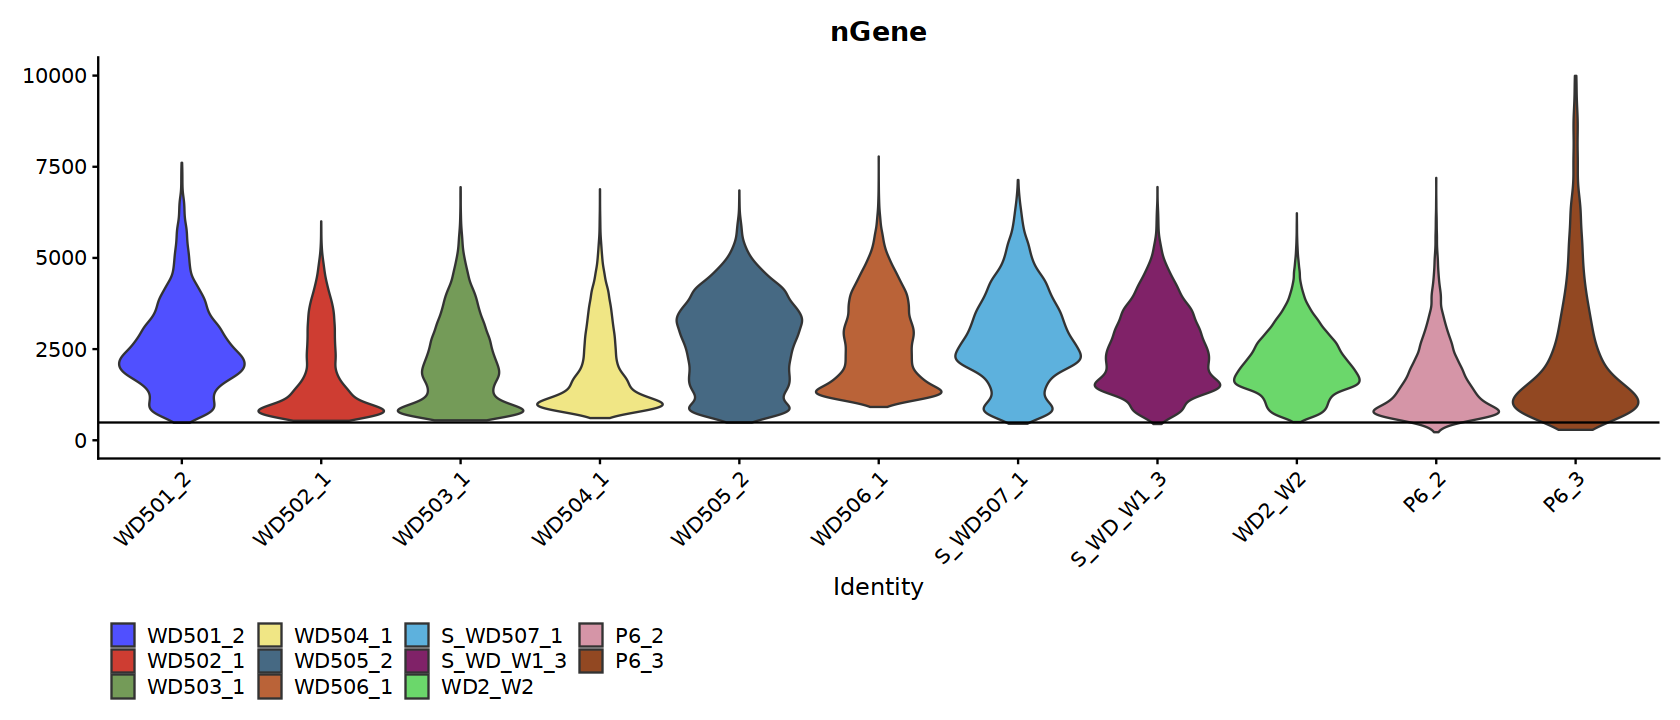

Warning message:
“Removed 5733 rows containing non-finite values (`stat_ydensity()`).”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 1 rows containing non-finite values (`stat_ydensity()`).”


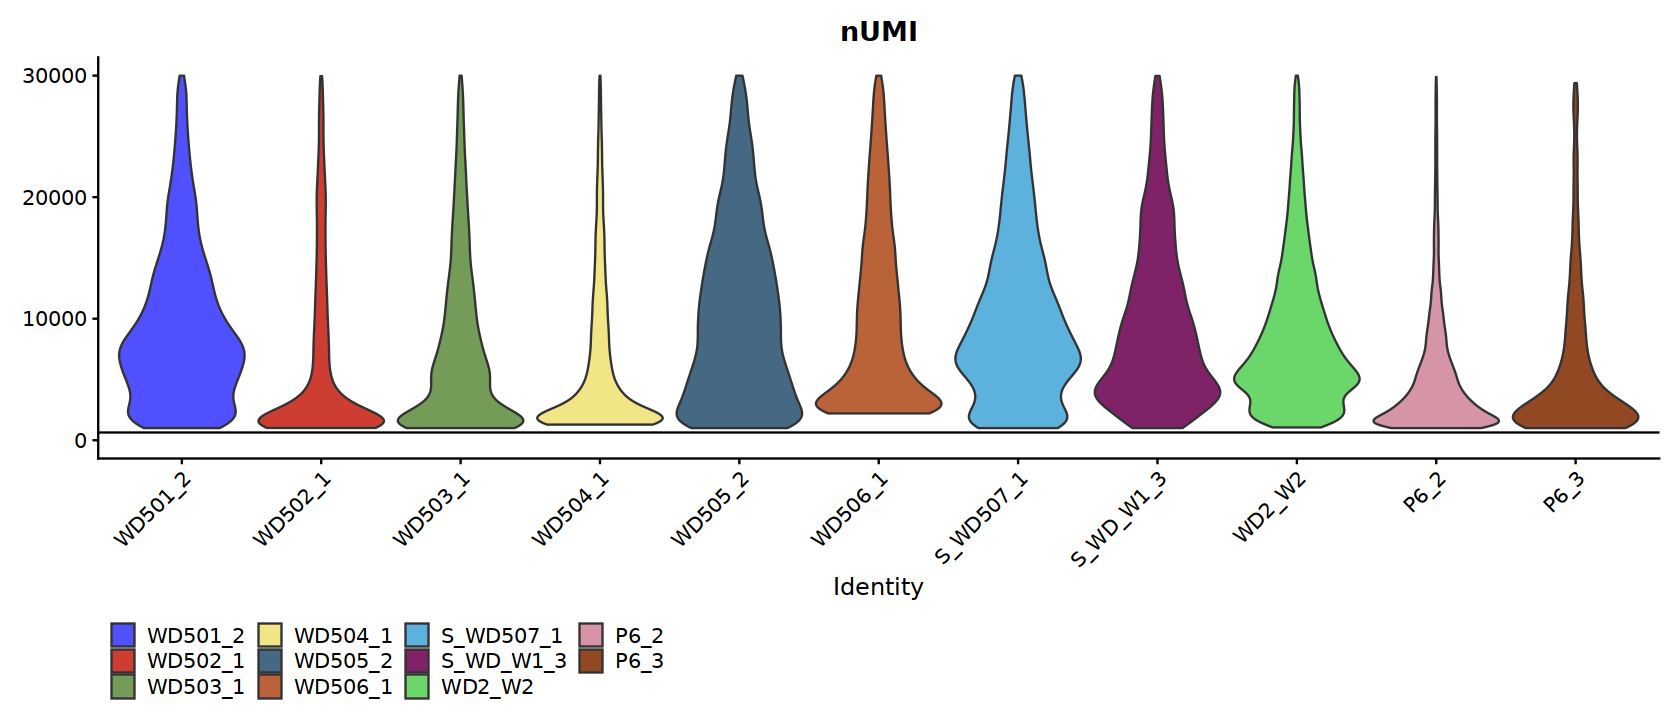

Warning message:
“Removed 1 rows containing non-finite values (`stat_ydensity()`).”


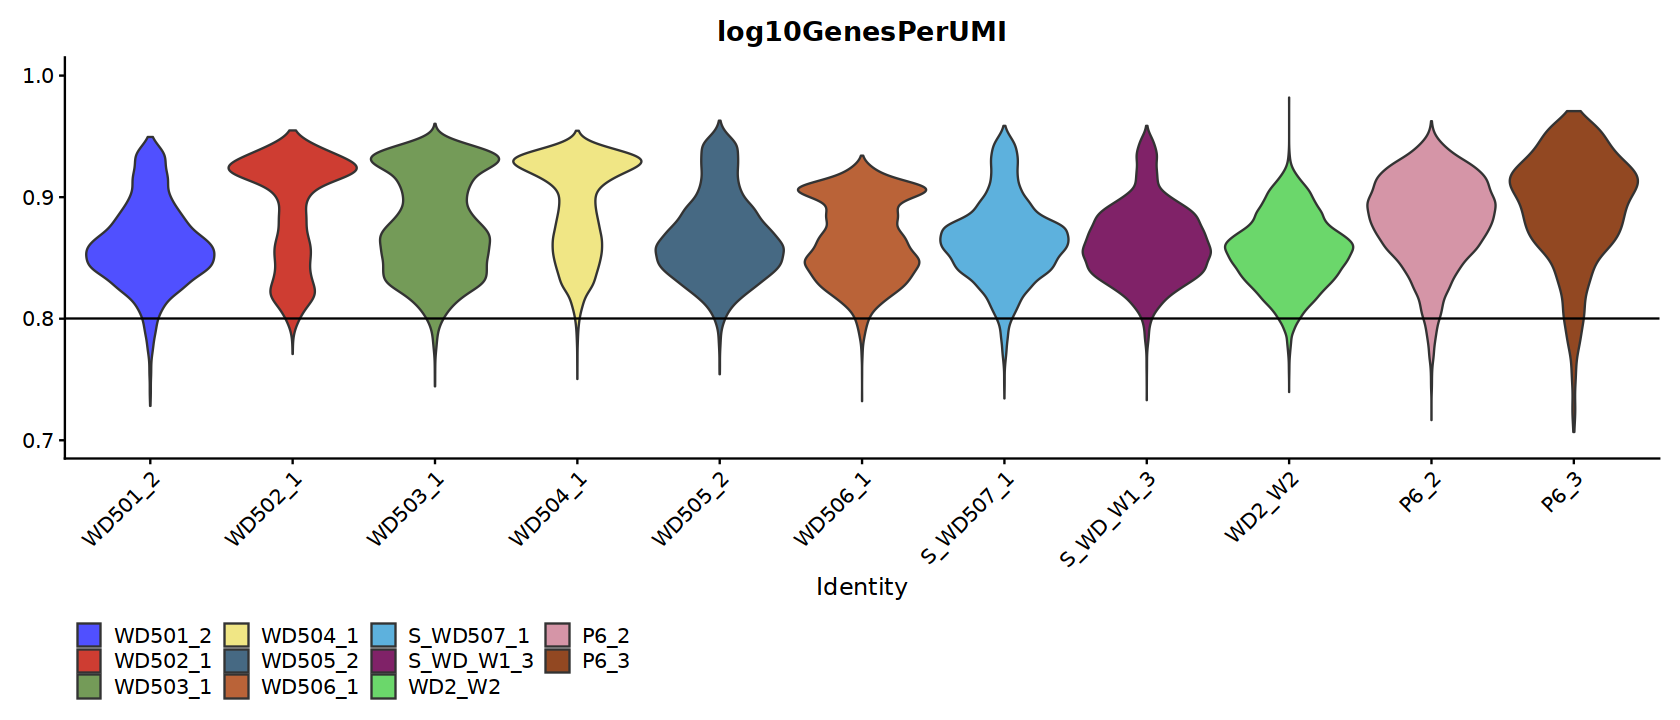

In [29]:

width=14
height=6
# gene="nGene"
options(repr.plot.width = width, repr.plot.height=height)
p<-print(VlnPlot(merged_seurat, features ="nGene",pt.size=0,cols = pal,group.by = "sample")+theme(legend.position = "bottom")+
         geom_hline(yintercept = 500)+
        scale_y_continuous(limits = c(0, 10000)))

ggsave(p,file=paste0(figuredir,'nGene_vinplot.pdf'),width = width,height = height)


p<-print(VlnPlot(merged_seurat, features ="nUMI",pt.size=0,cols = pal,group.by = "sample")+theme(legend.position = "bottom")+
         geom_hline(yintercept = 600)+
        scale_y_continuous(limits = c(0, 30000)))
ggsave(p,file=paste0(figuredir,'nUMI_vinplot.pdf'),width = width,height = height)

p<-print(VlnPlot(merged_seurat, features ="log10GenesPerUMI",pt.size=0,cols = pal,group.by = "sample")+theme(legend.position = "bottom")+
         geom_hline(yintercept = 0.8)+
        scale_y_continuous(limits = c(0.7, 1)))

ggsave(p,file=paste0(figuredir,'log10GenesPerUMI_vinplot.pdf'),width = width,height = height)

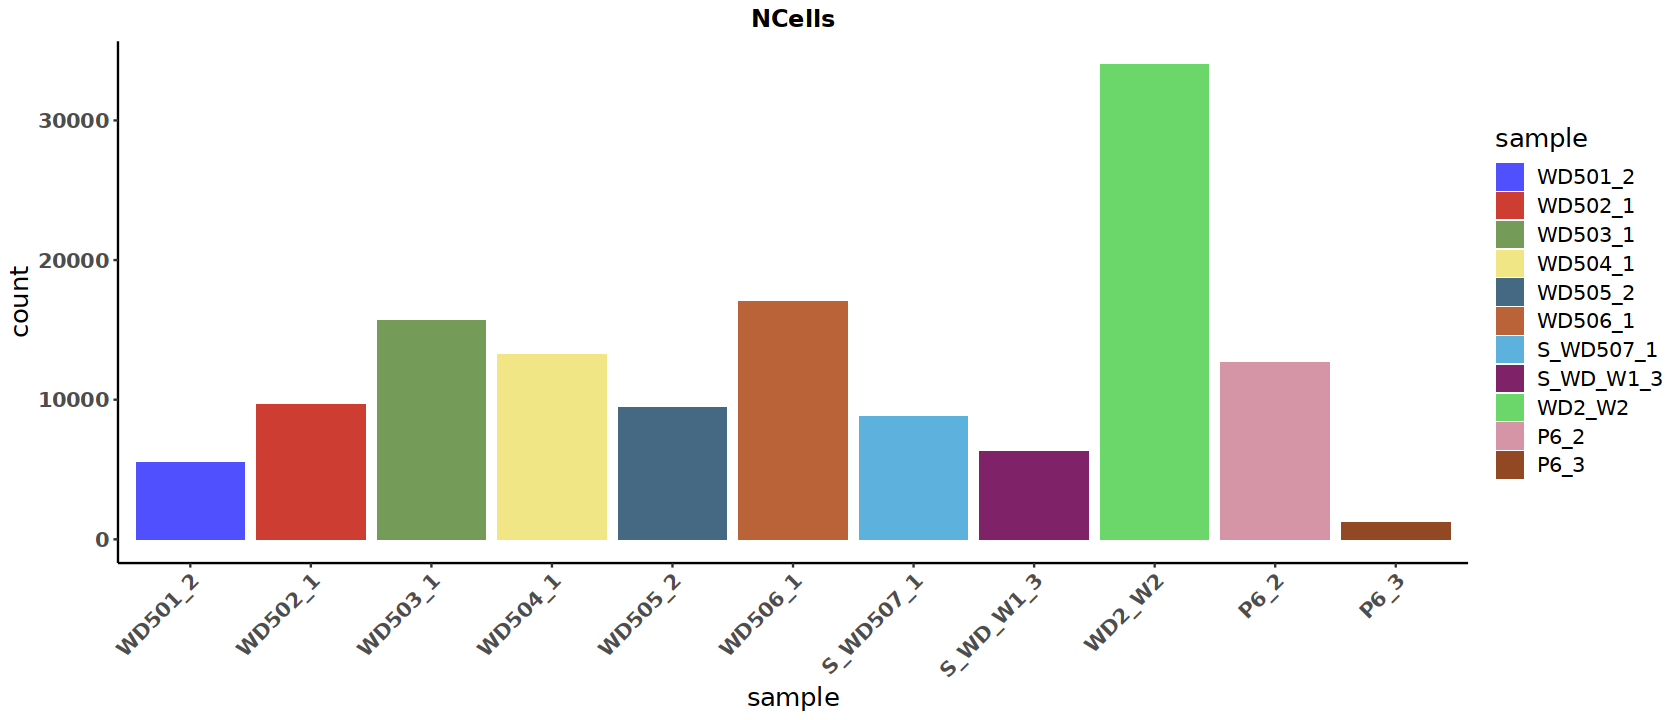

In [31]:
metadata<-merged_seurat@meta.data

# Visualize the number of cell counts per sample & type
p<-print(metadata %>%      
      ggplot(aes(x=sample, fill=sample)) +
      geom_bar() +
scale_fill_manual(values=pal)+
      theme_classic() +
      theme_classic() +
      theme(axis.text.x = element_text(angle = 45,vjust = 1, hjust=1,size = 12, face="bold")) +
 theme(axis.text.y = element_text(size = 12, face="bold")) +
      theme(plot.title = element_text(hjust=0.5, face="bold",size = 14)) +
theme(text = element_text(size = 15))+
      ggtitle("NCells"))
ggsave(p, filename="Ncells_sample.pdf", path=figuredir,width = 8,height = 8)


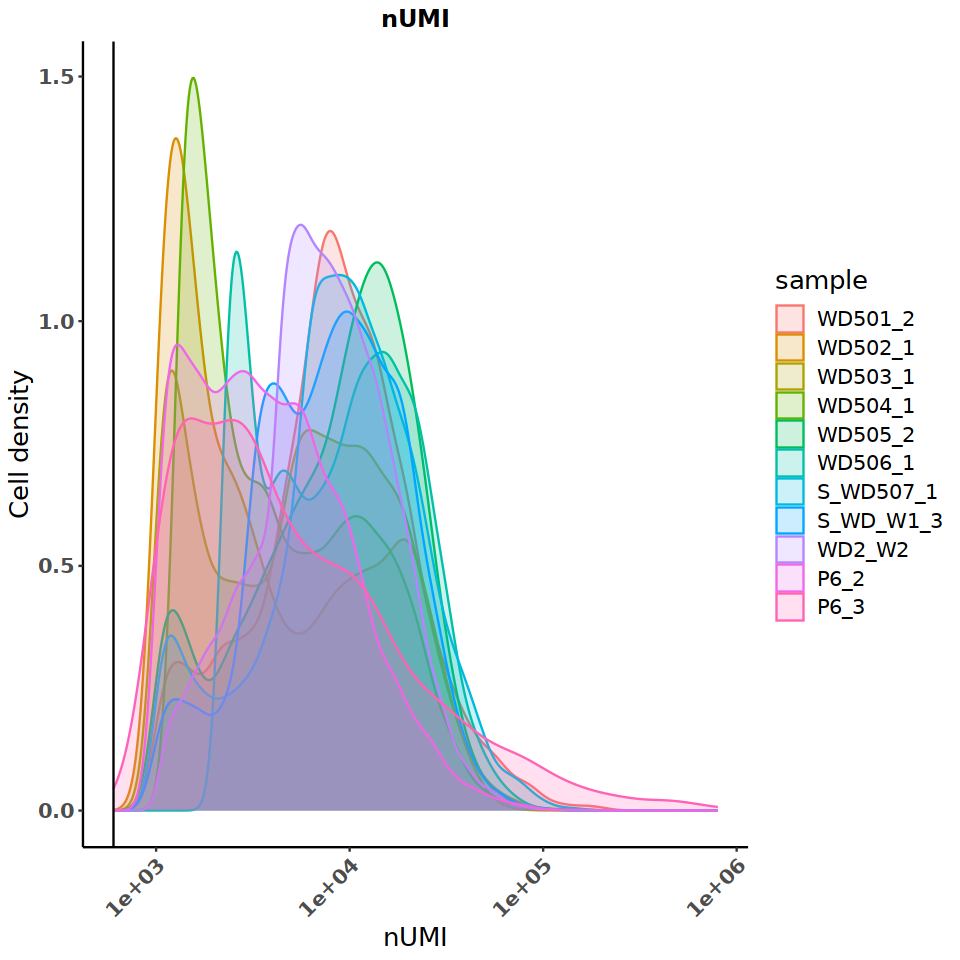

In [32]:
options(repr.plot.width = 8, repr.plot.height=8)
metadata<-merged_seurat@meta.data 
# Visualize the number UMIs/transcripts per cell
p<-print(metadata %>%
      ggplot(aes(color=sample, x=nUMI, fill= sample)) +
      geom_density(alpha = 0.2) +

      scale_x_log10() +
      theme_classic() +
# ylim(500,5000)+
      ylab("Cell density") +
      theme(axis.text.x = element_text(angle = 45,vjust = 1, hjust=1,size = 12, face="bold")) +
 theme(axis.text.y = element_text(size = 12, face="bold")) +
      theme(plot.title = element_text(hjust=0.5, face="bold",size = 14)) +
theme(text = element_text(size = 15))+
      geom_vline(xintercept =600)+
  ggtitle("nUMI"))

ggsave(p, filename="nUMI_sample.pdf", path=figuredir,width = 8,height = 8)


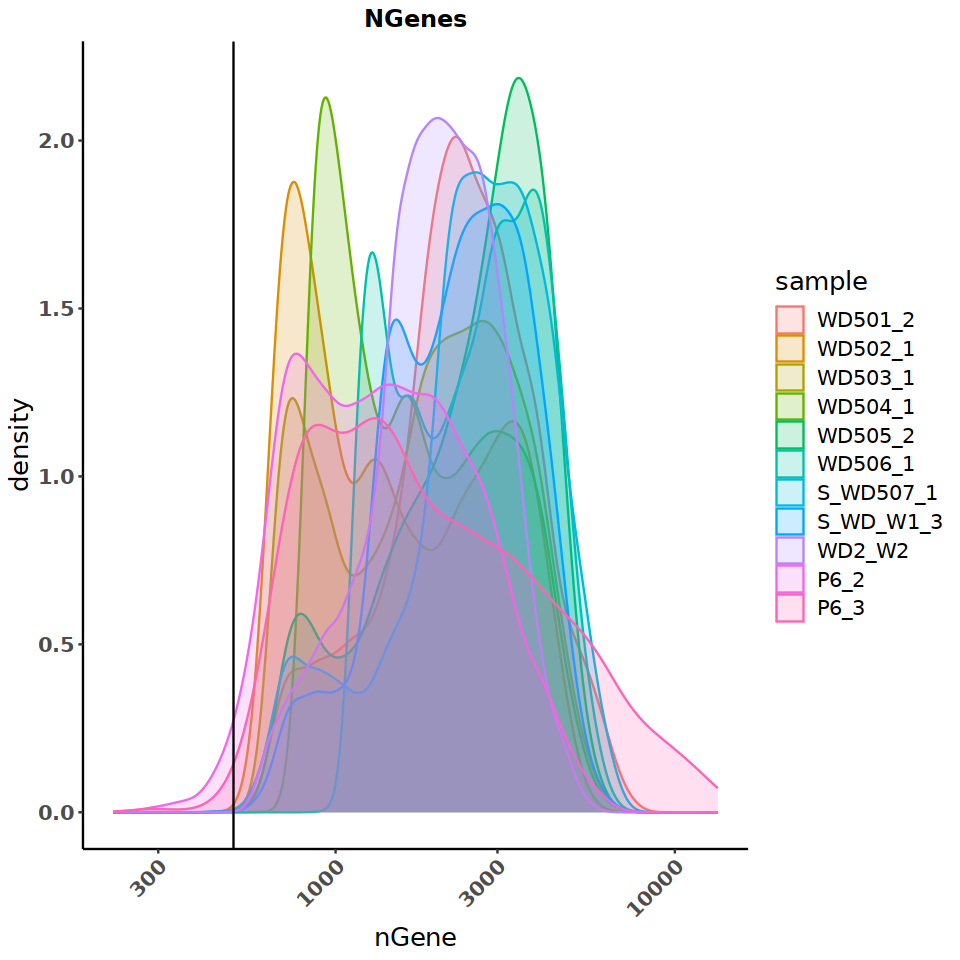

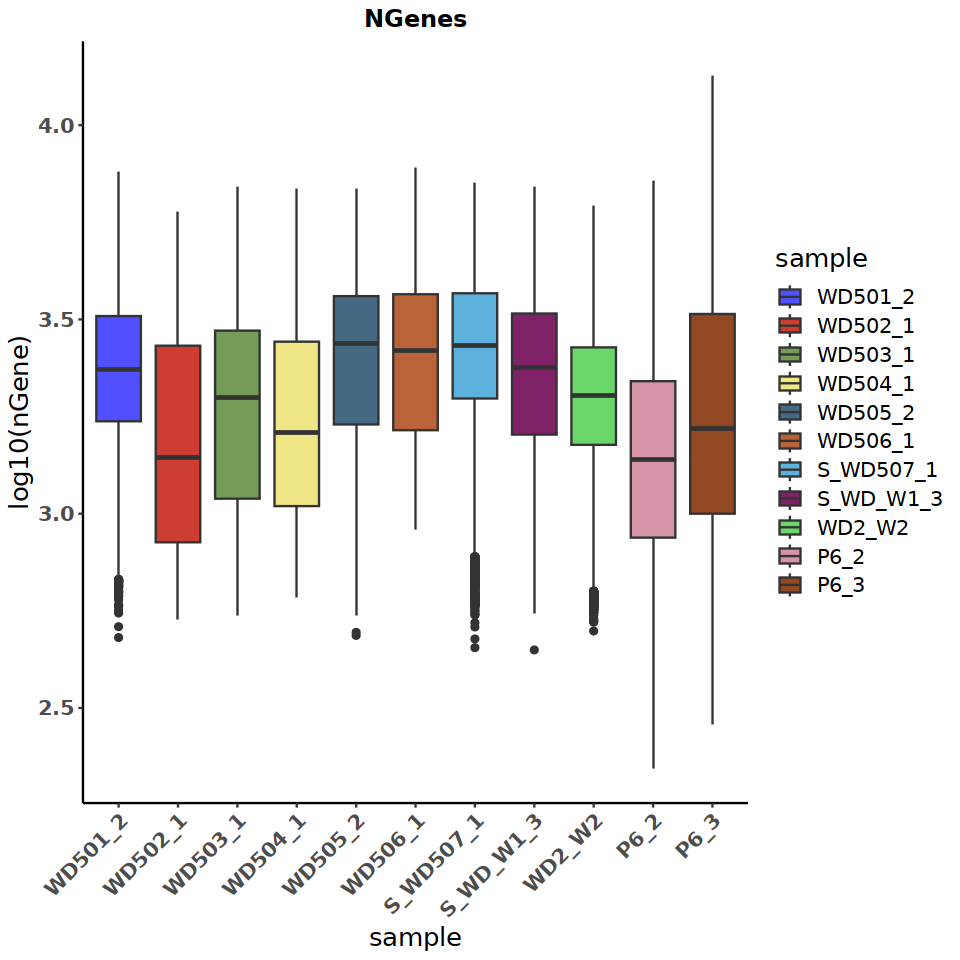

In [33]:
# Visualize the distribution of genes detected per cell via histogram
options(repr.plot.width = 8, repr.plot.height=8)
p<-print(metadata %>%
      ggplot(aes(color=sample, x=nGene, fill= sample)) +
      geom_density(alpha = 0.2) +
      theme_classic() +
      scale_x_log10() +
      theme(axis.text.x = element_text(angle = 45,vjust = 1, hjust=1,size = 12, face="bold")) +
 theme(axis.text.y = element_text(size = 12, face="bold")) +
      theme(plot.title = element_text(hjust=0.5, face="bold",size = 14)) +
theme(text = element_text(size = 15))+
      geom_vline(xintercept = 500)+
  ggtitle("NGenes"))
ggsave(p, filename="nGenes_density.pdf", path=figuredir,width = 8,height = 8)



# Visualize the distribution of genes detected per cell via boxplot
p<-print(metadata %>%
      ggplot(aes(x=sample, y=log10(nGene), fill=sample)) +
      geom_boxplot() +
scale_fill_manual(values=pal)+
      theme_classic() +
      theme(axis.text.x = element_text(angle = 45,vjust = 1, hjust=1,size = 12, face="bold")) +
 theme(axis.text.y = element_text(size = 12, face="bold")) +
      theme(plot.title = element_text(hjust=0.5, face="bold",size = 14)) +
theme(text = element_text(size = 15))+
      ggtitle("NGenes"))
ggsave(p, filename="nGenes_sample_boxplot.pdf", path=figuredir,width = 8,height = 8)



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


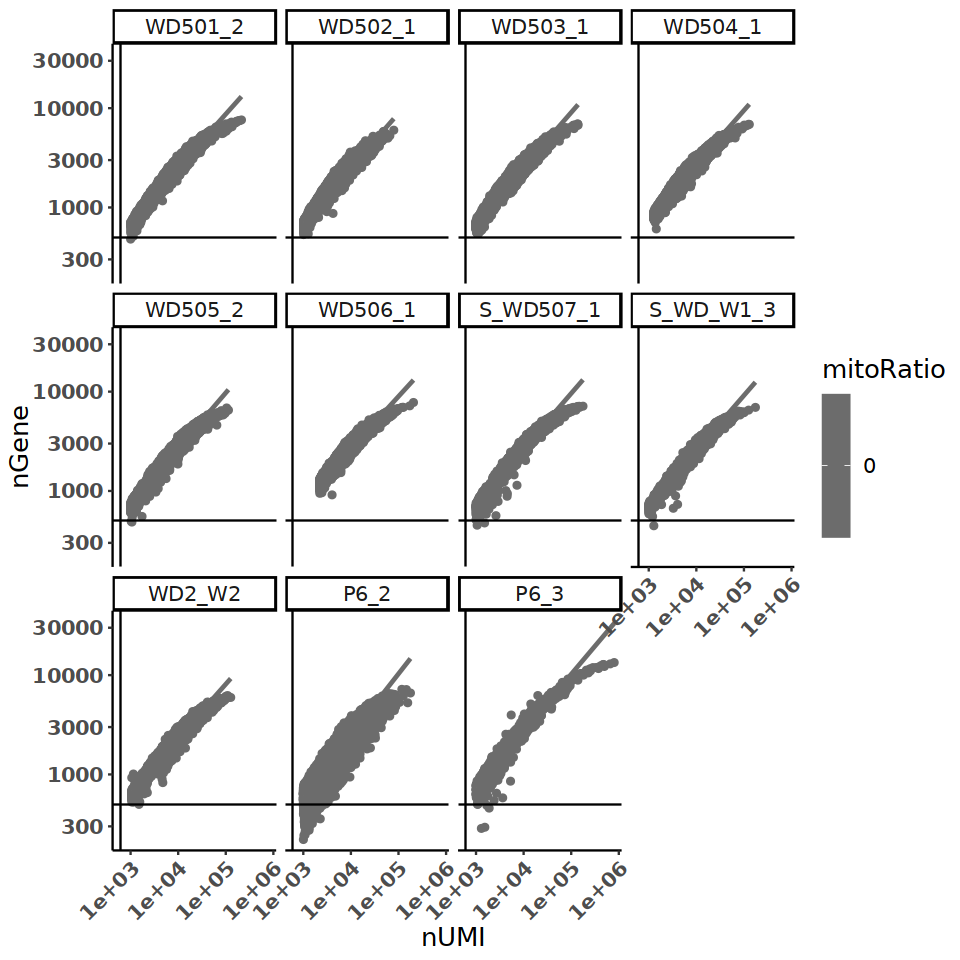

In [34]:
# Visualize the correlation between genes detected and number of UMIs and determine whether strong presence of cells with low numbers of genes/UMIs

p<-print(metadata %>%
      ggplot(aes(x=nUMI, y=nGene, color=mitoRatio)) +
      geom_point() +
      scale_colour_gradient(low = "gray90", high = "black") +
      stat_smooth(method=lm) +
      scale_x_log10() +
      scale_y_log10() +
      theme_classic() +
      geom_vline(xintercept = 600) +
      geom_hline(yintercept = 500) +
      theme(axis.text.x = element_text(angle = 45,vjust = 1, hjust=1,size = 12, face="bold")) +
 theme(axis.text.y = element_text(size = 12, face="bold")) +
      theme(plot.title = element_text(hjust=0.5, face="bold",size = 12)) +
theme(text = element_text(size = 15))+
      facet_wrap(~sample))

ggsave(p, filename="nGenes_nUMI_boxplot.pdf", path=figuredir,width = 8,height = 8)


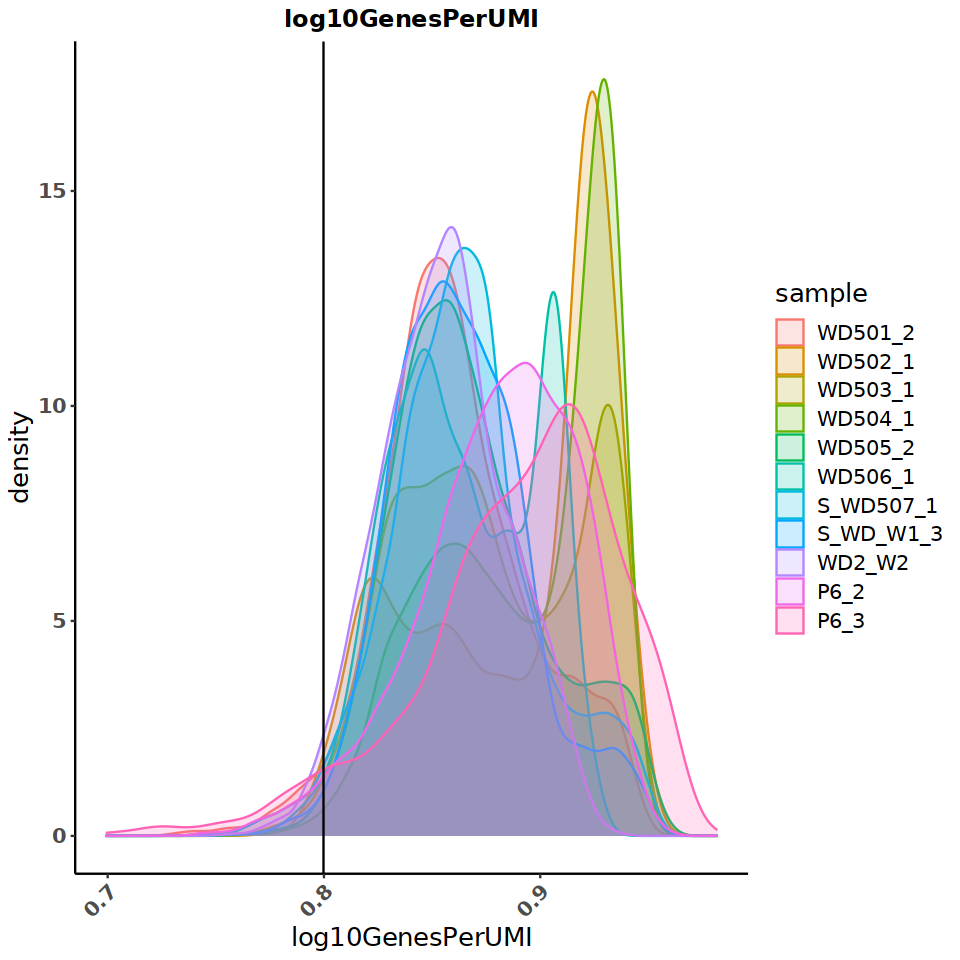

In [35]:
# Visualize the overall complexity of the gene expression by visualizing the genes detected per UMI
options(repr.plot.width = 8, repr.plot.height=8)
p<-print(metadata %>%
      ggplot(aes(x=log10GenesPerUMI, color = sample, fill=sample)) +
      geom_density(alpha = 0.2) +
      theme_classic() +
      theme(axis.text.x = element_text(angle = 45,vjust = 1, hjust=1,size = 12, face="bold")) +
 theme(axis.text.y = element_text(size = 12, face="bold")) +
      theme(plot.title = element_text(hjust=0.5, face="bold",size = 14)) +
theme(text = element_text(size = 15))+
      geom_vline(xintercept = 0.8)+
  ggtitle("log10GenesPerUMI"))

ggsave(p, filename="log10GenesPerUMI.pdf", path=figuredir,width = 8,height = 8)


In [36]:
# hist(merged_seurat@meta.data$log10GenesPerUMI)
quantile(merged_seurat@meta.data$nUMI,0.95)
max(merged_seurat@meta.data$nUMI)

95% 
28462.2

[1] 799403

In [37]:
# add UMI filter  
max_UMI<-quantile(merged_seurat@meta.data$nUMI, 0.95)
max_UMI

95% 
28462.2

In [38]:
# Filter out low quality reads using selected thresholds - these will change with experiment
filtered_seurat <- subset(x = merged_seurat,
                         subset= (nUMI >= 600) &
                           (nGene >= 500) &
                           (log10GenesPerUMI > 0.80) &
                           (mitoRatio < 0.05) &
                         (nUMI<max_UMI))

In [39]:
# Create .RData object to load at any time
save(filtered_seurat, file=paste0(resultdir,"seurat_filtered.RData"))

In [5]:
load(file=paste0(resultdir,"seurat_filtered.RData"))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


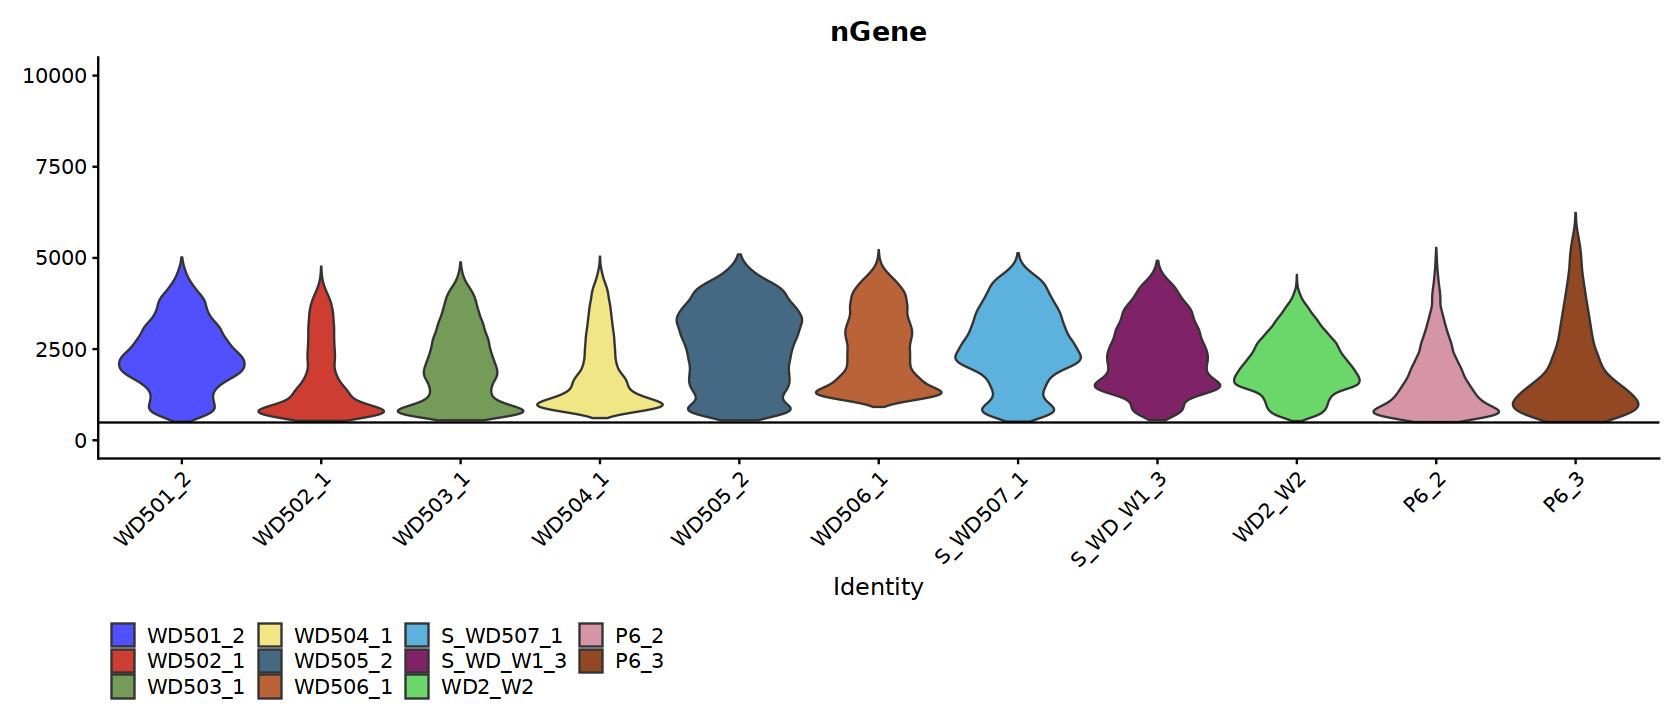

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


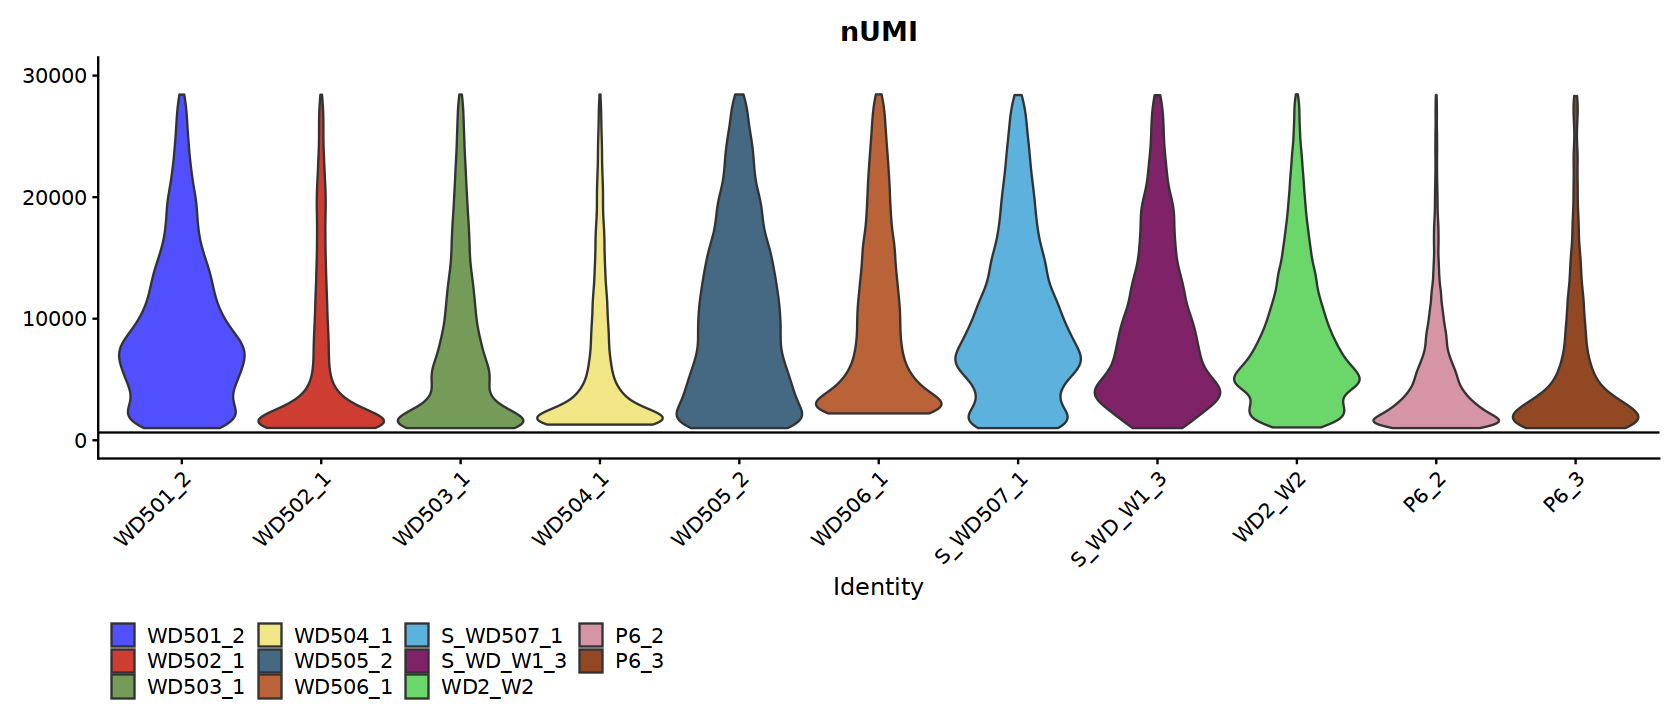

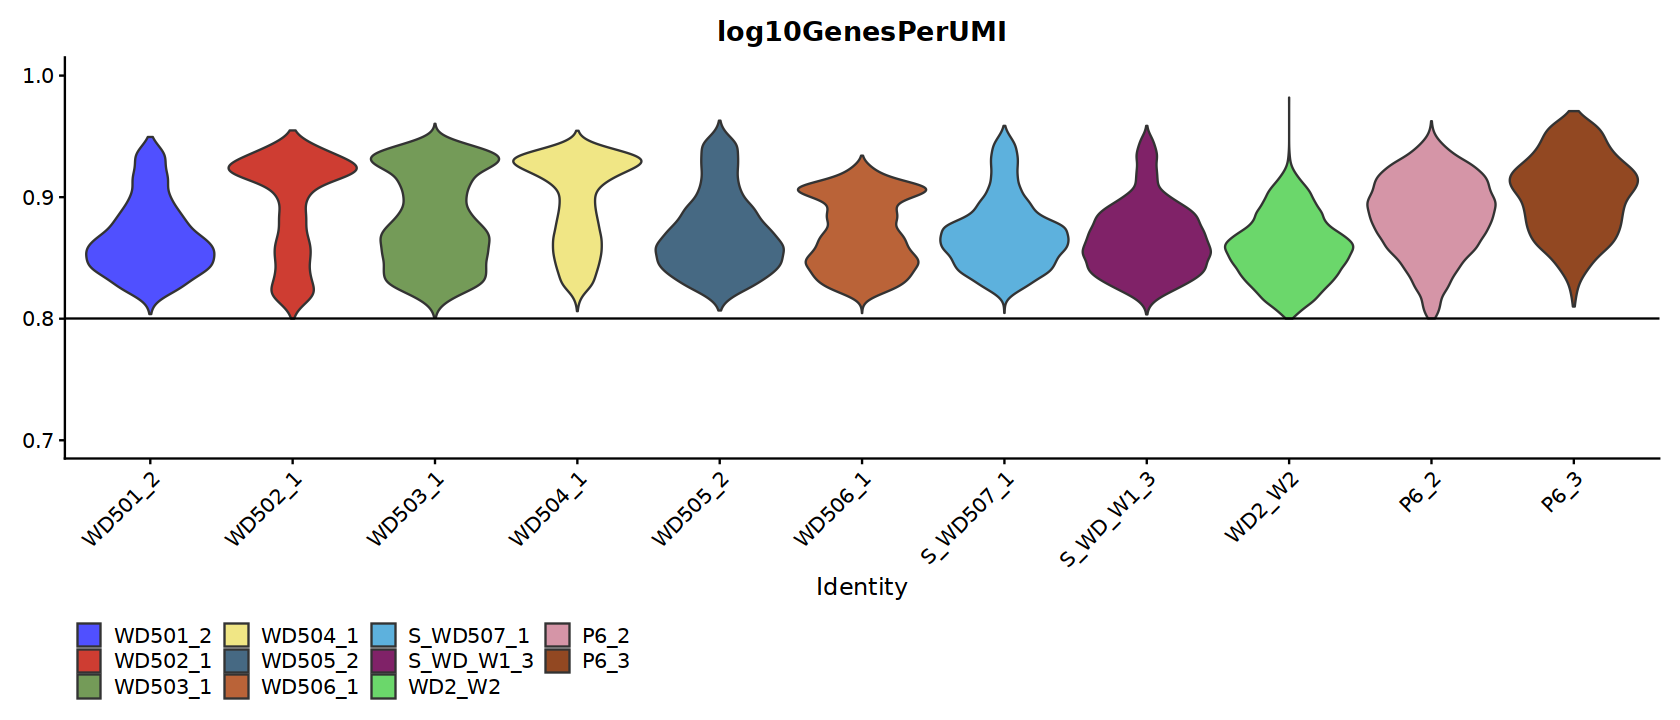

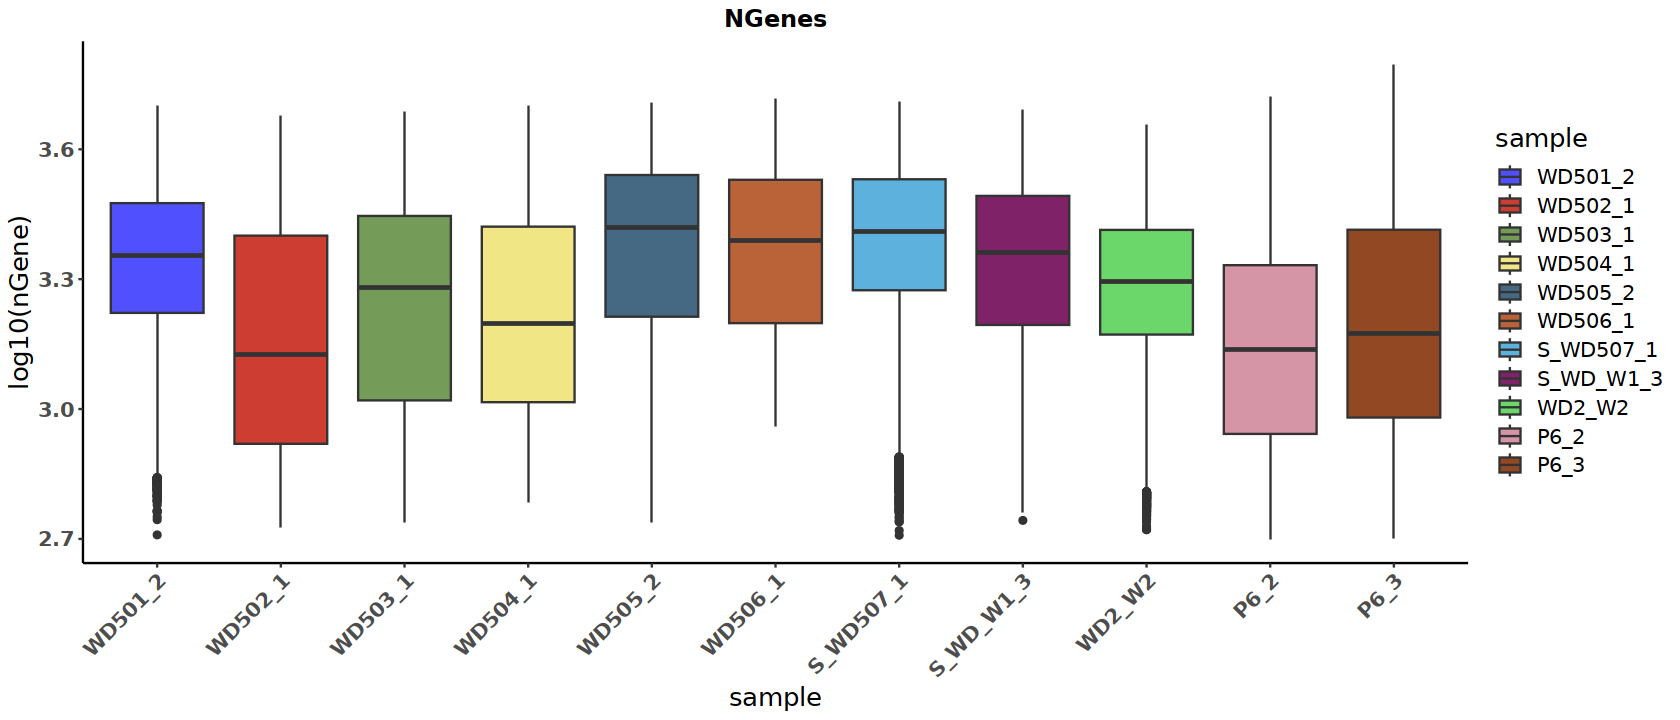

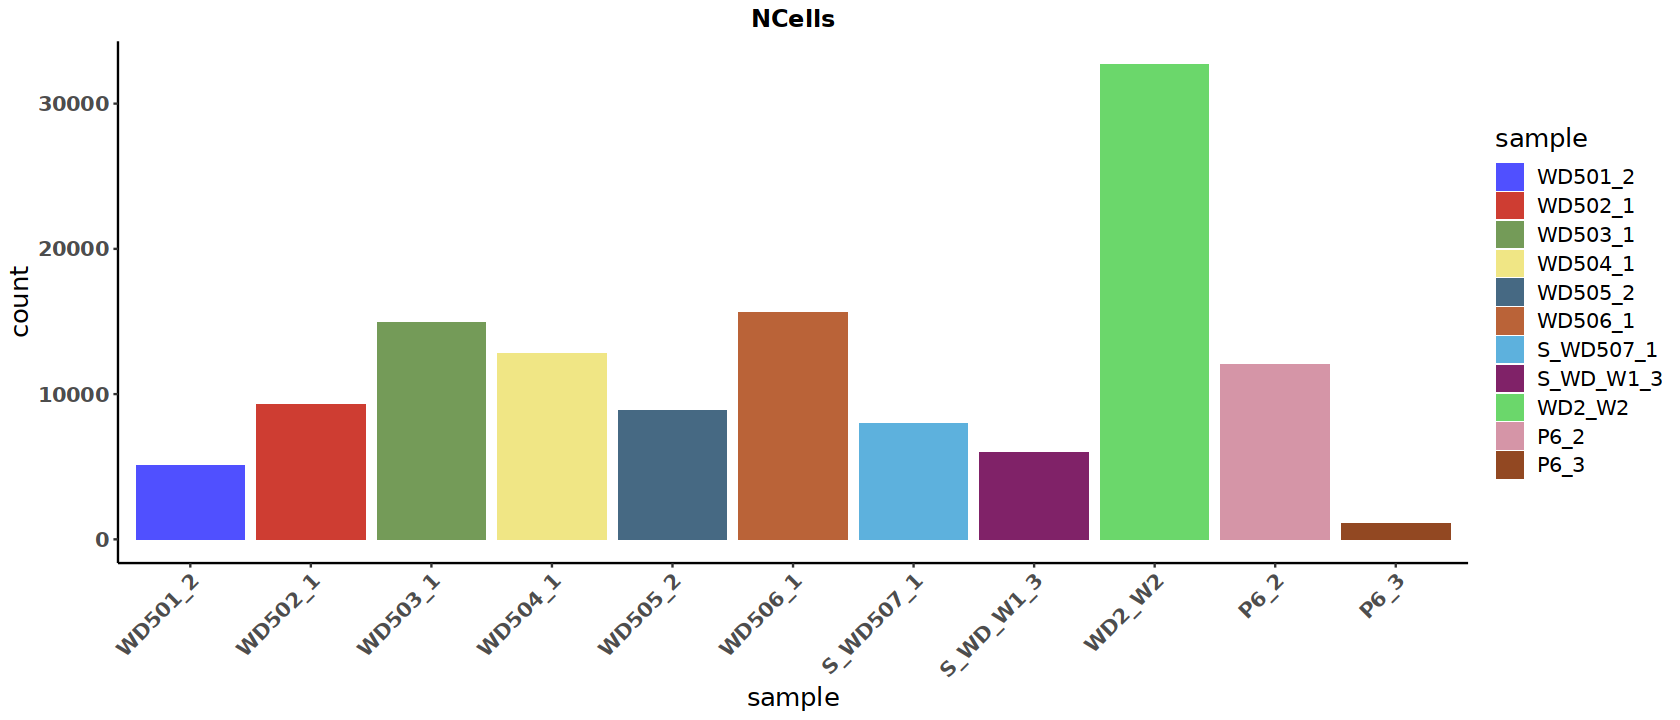

In [40]:
# after filter 
width=14
height=6
# gene="nGene"
options(repr.plot.width = width, repr.plot.height=height)
p<-print(VlnPlot(filtered_seurat, features ="nGene",pt.size=0,cols = pal,group.by = "sample")+theme(legend.position = "bottom")+
         geom_hline(yintercept = 500)+
        scale_y_continuous(limits = c(0, 10000)))

ggsave(p,file=paste0(figuredir,'filtered_nGene_vinplot.pdf'),width = width,height = height)


p<-print(VlnPlot(filtered_seurat, features ="nUMI",pt.size=0,cols = pal,group.by = "sample")+theme(legend.position = "bottom")+
         geom_hline(yintercept = 600)+
        scale_y_continuous(limits = c(0, 30000)))
ggsave(p,file=paste0(figuredir,'filtered_nUMI_vinplot.pdf'),width = width,height = height)

p<-print(VlnPlot(filtered_seurat, features ="log10GenesPerUMI",pt.size=0,cols = pal,group.by = "sample")+theme(legend.position = "bottom")+
         geom_hline(yintercept = 0.8)+
        scale_y_continuous(limits = c(0.7, 1)))

ggsave(p,file=paste0(figuredir,'filtered_log10GenesPerUMI_vinplot.pdf'),width = width,height = height)

metadata<-filtered_seurat@meta.data
p<-print(metadata %>%
      ggplot(aes(x=sample, y=log10(nGene), fill=sample)) +
      geom_boxplot() +
scale_fill_manual(values=pal)+
      theme_classic() +
      theme(axis.text.x = element_text(angle = 45,vjust = 1, hjust=1,size = 12, face="bold")) +
 theme(axis.text.y = element_text(size = 12, face="bold")) +
      theme(plot.title = element_text(hjust=0.5, face="bold",size = 14)) +
theme(text = element_text(size = 15))+
      ggtitle("NGenes"))
ggsave(p, filename="filtered_nGenes_sample_boxplot.pdf", path=figuredir,width = 8,height = 8)

p<-print(metadata %>%      
      ggplot(aes(x=sample, fill=sample)) +
      geom_bar() +
scale_fill_manual(values=pal)+
      theme_classic() +
      theme_classic() +
      theme(axis.text.x = element_text(angle = 45,vjust = 1, hjust=1,size = 12, face="bold")) +
 theme(axis.text.y = element_text(size = 12, face="bold")) +
      theme(plot.title = element_text(hjust=0.5, face="bold",size = 14)) +
theme(text = element_text(size = 15))+
      ggtitle("NCells"))
ggsave(p, filename="filtered_Ncells_sample.pdf", path=figuredir,width = 8,height = 8)
